# Brief tutorial before starts

This is for practicing to understand how linear regression works. 

In this chapter, we will learn about:

- Linear Basis Function Models

- The Bias-Variance Decomposition

To do that, you need to download (or install) the JAX(https://github.com/google/jax) first.

JAX is the library from Google, which is for tensor calculation like Numpy and automatic differentiation like PyTorch or TensorFlow.

You can install it by executing under cell commmand.

In [1]:
!pip install jax

Defaulting to user installation because normal site-packages is not writeable


As I said, JAX has the ability of automatic differentiation. You can do differentiation with jax.grad

I will show the example of how it works.

In [2]:
from jax import grad
from jax import vmap # vmap is function that makes be able to calculate as vectorized form
from jax import numpy as np # jax has customized numpy implementation by own.


def f(x):
    return x**2 # return x^2 as output

# important information: If you want to get inputs as vectorized form, you need to use 'vmap'.

g = vmap(grad(f)) # calculate the (x^2)' and assign this function to g 

x = np.arange(10, dtype=np.float32) # returned value will be 'DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=float32)'


print(f(x)) # print x^2 
print(g(x)) # print (x^2)'

[ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


If you want to plot the point, then you can use matplotlib. 
Also you can install it by executing under cell command. 

In [3]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


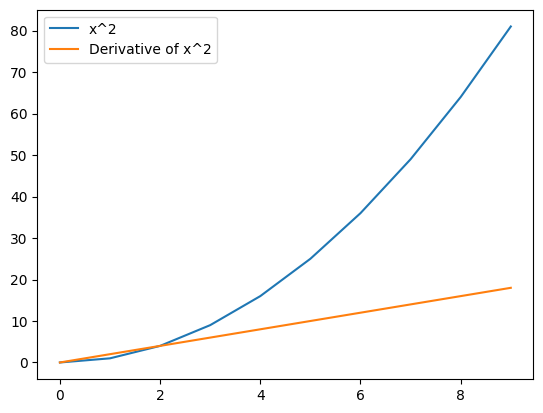

In [4]:
import matplotlib.pyplot as plt

plt.plot(x, f(x), label='x^2')
plt.plot(x, g(x), label='Derivative of x^2')
plt.legend()
plt.show()
plt.close()

This was the brief tutorial to use JAX and matplotlib. If you want to see more functions and tutorials, then you can visit these websites.

- https://matplotlib.org/
- https://jax.readthedocs.io/en/latest/

# Linear Basis Function Models

You can think the simplest linear model for regression is linear combination of the input variables

$$
f(\textbf{x}, \textbf{w}) = w_0+ w_1x_1 + w_2x_2 + ... + w_nx_n, 
x_n \in \textbf{x}, w_n \in \textbf{w}
$$

And if we set $x_0= 1$, hence, we can write $ f(\textbf{x}, \textbf{w}) $ as the form of matrix multiplication like under below:

$$
f(\textbf{x}, \textbf{w}) =  \textbf{w}^{T}\textbf{x}
$$
where the notation $T$ means the transposing the vector or matrix.

We can test this method into the codes like under below. ( $n= 1$)

In [5]:
from jax import random

# Random seed should be explicit in JAX, numbers are randomly sampled from human head

key_bias = random.PRNGKey(10213)  
key_weight = random.PRNGKey(32141) 
key_data = random.PRNGKey(52411) 

# Define input data and parameters

X = np.tile(np.arange(10, dtype=np.float32), (100,1))


W = random.normal(key_weight, shape=(1,), dtype=np.float32) # random sampling W ~ N(0, 1)
w0 = random.normal(key_weight, shape=(1,), dtype=np.float32)


# mean of Sampling function: f(x) = 3.14x + 15.92

def m_sampling_func(X):
    return 3.14*X + 15.92

# dumb_func: function that should learn W and w0

def dumb_func(X):
    return W*X + w0

Y = m_sampling_func(X) # generate truth data with noise from X

# Adding noise p ~ N(0,1) (100 shots)

for i in range(len(X)):
    Y = Y.at[i].set(Y[i]+ random.normal(random.PRNGKey(i), (10,)))


We can plot the data Y and the function m_sampling_func  and dumb_func which will be trained as follows:

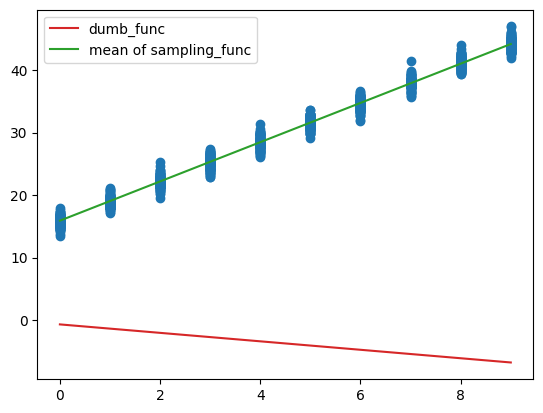

In [6]:
for i in range(len(X)):
    plt.scatter(X[i],Y[i], color='tab:blue')


plt.plot(X[0], dumb_func(X[0]), color='tab:red', label='dumb_func')
plt.plot(X[0], m_sampling_func(X[0]), color='tab:green', label='mean of sampling_func')

plt.legend()
plt.show()
plt.close()

Define the target value vector as $\bf t$, which is sampled from correct_func(X)+$\epsilon$.

Because $ \textit{N}(\alpha,\beta)$ can be represented as $ \alpha + \beta\textit{N}(0,1)$, we can think correct_func(X)+$\epsilon$ as normal distribution when $\epsilon$ follows normal distribution. 

Then it is possible to think the likelihood function as:
$$
p(\textbf{t}|\textbf{X},\textbf{w}, \beta) = \prod_{n=1}^{N} \textit{N}(t_n|\textbf{w}^{T}x_n,\beta^{-1})
$$

We can take natural log on each side, 

$$
\ln{p(\textbf{t}|\textbf{X},\textbf{w}, \beta)} = \ln{\prod_{n=1}^{N} \textit{N}(t_n|\textbf{w}^{T}x_n,\beta^{-1})} = \frac{N}{2}\ln{\beta} - \frac{N}{2}\ln{2\pi} - \beta \frac{1}{2} \sum_{n=1}^{N} (t_n - \textbf{w}^{T}\textbf{x}_n)^2,\\ \textbf{x}_n \in \textbf{X}
$$ 

Because $\frac{N}{2}\ln{\beta} - \frac{N}{2}\ln{2\pi}$ is constant, we should minimize $\frac{1}{2}\sum_{n=1}^{N} (t_n - \textbf{w}^{T}\textbf{x}_n)^2$, let this function as $E_D$, we called this function as $\textbf{loss}$ function or $\textbf{error}$ function. (Additional note: it is not required to set the loss function including $ \frac{1}{2}$, but for convenience of calculating the differentiation, I expect the author add the term $ \frac{1}{2}$)

we can take the gradient from each side, then we have:
$$
\nabla \ln{p(\textbf{t}|\textbf{X},\textbf{w}, \beta)} = \beta \sum_{n=1}^{N} (t_n - \textbf{w}^{T}\textbf{x}_n)x_n^{T}
$$

We can solve this function by setting $ \nabla \ln{p} $ as 0.

$$
\textbf{w}_{ans} = (x_{n,m}^{T}x_{n,m})^{-1}x_{n,m}^{T} \textbf{t}
$$

It is hard to control when $ x_1 = 1$, if we decompose $ w_1$ from the formula,

Then we can rewrite the loss function as:
$$
\frac{1}{2}\sum_{n=1}^{N} (t_n - w_0 - (\sum_{j=1}^{M-1}w_{j}\textbf{x}_j))^2,
$$

Suppose the result of this loss function is 0, then we can write this function as:
$$
w_0 = \bar{t} - \sum_{j=1}^{M-1}w_jx_j
$$

where $\bar{t}$ is the average of target values.

from this equation, we can understand that $w_1$, the bias, is for calibrating of the average of expected function to the average of target values.

Let me find the $w_{ans}$ and $w_1$ in this case by using codes.

In [7]:
# First, we need to set target value (the average of each point)

t = Y.mean(axis=0)

# we can calculate the parameters from the equation that we have got 

# term for bias and term for weight

inputs = np.array([[1.0,0.0],[1.0,1.0],[1.0,2.0],[1.0,3.0],[1.0,4.0],[1.0,5.0],[1.0,6.0],[1.0,7.0],[1.0,8.0],[1.0,9.0]], dtype=np.float32)


params = np.linalg.inv(inputs.T @ inputs) @ (inputs.T @ t)

print(f'the weight is: {params[1]} and bias is: {params[0]}')

# define smart func

def smart_func(X):
    return params[0] + params[1]*x 

# Evaluate the sampling func and smart_func 


err_dumb = (Y-dumb_func(X))**2
err_smart = (Y-smart_func(X))**2
err_original = (Y-m_sampling_func(X))**2


original_MSE = np.mean(err_original)
smart_MSE = np.mean(err_smart)
dumb_MSE = np.mean(err_dumb)



print(f'MSE from mean of sampling function: {original_MSE}')
print(f'MSE from dumb_func function: {dumb_MSE}')
print(f'MSE from smart_func of sampling function: {smart_MSE}')


the weight is: 3.16278338432312 and bias is: 15.796297073364258
MSE from mean of sampling function: 0.8863493800163269
MSE from dumb_func function: 1261.7203369140625
MSE from smart_func of sampling function: 0.8816173672676086


From this result, you can check the variance of normal distribution, $\beta^{-1}$ is almost same as the MSE of **smart_func**, because the parameters of **smart_func** are $\textbf{w}_{ML}$

And we can plot each function as like under below 

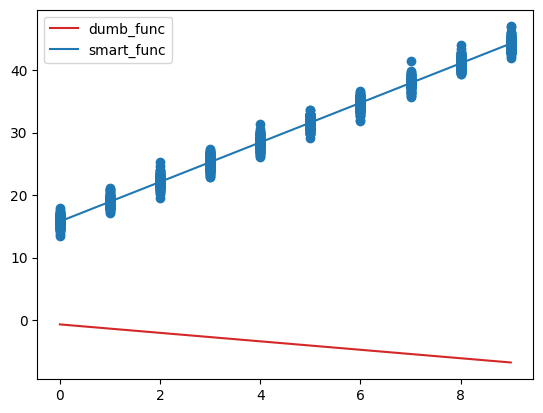

In [8]:
for i in range(len(X)):
    plt.scatter(X[i],Y[i], color='tab:blue')


plt.plot(X[0], dumb_func(X[0]), color='tab:red', label='dumb_func')
plt.plot(X[0], smart_func(X[0]), color='tab:blue', label='smart_func')


plt.legend()
plt.show()
plt.close()

But because this function is only composed with a linear combination of the input variables, therefore it cannot represent the inputs from non-linear basis function like sigmoid

In [9]:
def not_good_to_sample_func(X):
    return 100/(1+np.exp(-X))

X = np.tile(np.arange(start=-8, stop=8, step=1.6, dtype=np.float32), (100,1))
Y = not_good_to_sample_func(X) # generate truth data from sigmoid function

# Adding noise p ~ N(0,1) (100 shots)

for i in range(len(X)):
    Y = Y.at[i].set(Y[i]+ random.normal(random.PRNGKey(i), (10,)))


If we plot these things, then it is equal as:

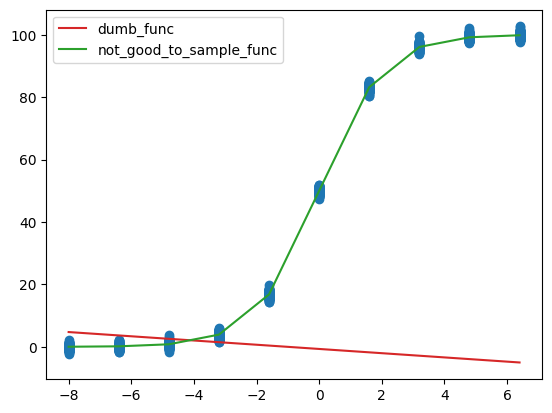

In [10]:
for i in range(len(X)):
    plt.scatter(X[i],Y[i], color='tab:blue')


plt.plot(X[0], dumb_func(X[0]), color='tab:red', label='dumb_func')
plt.plot(X[0], not_good_to_sample_func(X[0]), color='tab:green', label='not_good_to_sample_func')

plt.legend()
plt.show()
plt.close()

Even if we train this dumb_func to smart_func...

In [11]:
# First, we need to set target value (the average of each point)

t = Y.mean(axis=0)

# we can calculate the parameters from the equation that we have got 

# term for bias and term for weight

inputs = np.array([[1.0,-8.0],[1.0,-6.4],[1.0,-4.8],[1.0,-3.2],[1.0,-1.6],[1.0,0.0],[1.0,1.6],[1.0,3.2],[1.0,4.8],[1.0,6.4]], dtype=np.float32)


params = np.linalg.inv(inputs.T @ inputs) @ (inputs.T @ t)

print(f'the weight is: {params[1]} and bias is: {params[0]}')

# define smart func

def smart_but_dumb_func(X):
    return params[0] + params[1]*x 

# Evaluate the sampling func and smart_func 


err_dumb = (Y-dumb_func(X))**2
err_smart = (Y-smart_but_dumb_func(X))**2
err_original = (Y-not_good_to_sample_func(X))**2


original_MSE = np.mean(err_original)
smart_MSE = np.mean(err_smart)
dumb_MSE = np.mean(err_dumb)



print(f'MSE from mean of sampling function: {original_MSE}')
print(f'MSE from dumb_func function: {dumb_MSE}')
print(f'MSE from smart_but_dumb_func of sampling function: {smart_MSE}')

the weight is: 8.873042106628418 and bias is: 52.080604553222656
MSE from mean of sampling function: 0.8863495588302612
MSE from dumb_func function: 4155.75244140625
MSE from smart_but_dumb_func of sampling function: 2639.3408203125


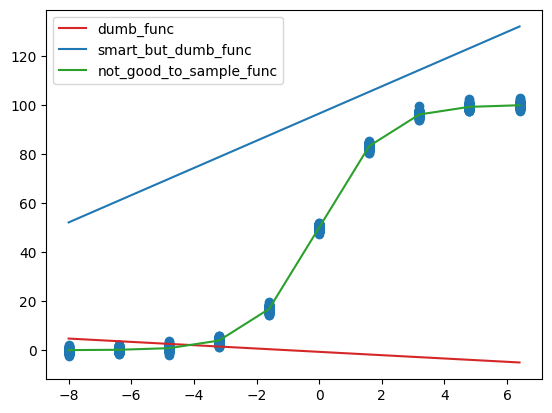

In [12]:
for i in range(len(X)):
    plt.scatter(X[i],Y[i], color='tab:blue')


plt.plot(X[0], dumb_func(X[0]), color='tab:red', label='dumb_func')
plt.plot(X[0], smart_but_dumb_func(X[0]), color='tab:blue', label='smart_but_dumb_func')
plt.plot(X[0], not_good_to_sample_func(X[0]), color='tab:green', label='not_good_to_sample_func')


plt.legend()
plt.show()
plt.close()

Hence we should define new types of linear model as under below.

$$
f(X, W) = w_0 + \sum_{j=0}^{M-1} w_j\phi_j(X), w_i \in W 
$$

function $\phi_j(X)$ are basis functions which add the complexity.

The parameter $w_0$ is called 'bias' (some adding factor of this parametrized model, not confused the term bias in statistics). And if we define the $\phi_0(X) = 1$, then we can express over equation as the form of matrix multiplication like under below.

$$
f(X, W) = W^T \bf{\phi}(X) 
$$ 

As the same process like over below, we can get the generalized form of closed solution of linear regression like under below:

$$
\textbf{w}_{ans} = (\Phi^{T}\Phi)^{-1}\Phi^{T}\textbf{t}
$$

when $\Phi$ is equal as under below:

$$
\Phi = \begin{pmatrix}
\phi_0(\textbf{x}_1) & \phi_1(\textbf{x}_1) & \phi_2(\textbf{x}_1) & \cdots &\phi_{M-1}(\textbf{x}_1)\\
\phi_0(\textbf{x}_2) & \phi_1(\textbf{x}_2) & \phi_2(\textbf{x}_2) & \cdots &\phi_{M-1}(\textbf{x}_2)\\
\phi_0(\textbf{x}_3) & \phi_1(\textbf{x}_3) & \phi_2(\textbf{x}_3) & \cdots &\phi_{M-1}(\textbf{x}_3)\\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\phi_0(\textbf{x}_N) & \phi_1(\textbf{x}_N) & \phi_2(\textbf{x}_N) & \cdots &\phi_{M-1}(\textbf{x}_N)\\
\end{pmatrix}
$$



Your task is to design **brilliant_func** and find the parameters of it to approximate the outputs from not_good_to_sample_func by using closed-form solution of linear regression, via maximum likelihood estimation.